In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


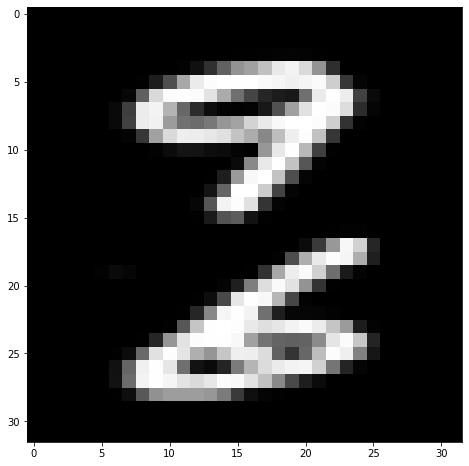

In [3]:
%matplotlib inline

from skimage.transform import resize
    
# obtain one batch of training images

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

im = np.concatenate([images[0], images[1]], axis = 1)
im = resize(im, (1, 32, 32))
ax.imshow(np.squeeze(im), cmap='gray')

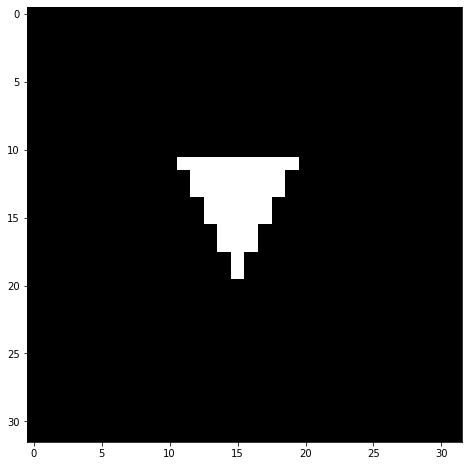

In [4]:
from skimage.draw import polygon
from torchvision import datasets, transforms

img = np.zeros((32, 32), dtype=np.uint8)
r = np.array([11, 11, 19])
c = np.array([11, 19, 15])
rr, cc = polygon(r, c)
img[rr, cc] = 1

fig = plt.figure(figsize=(8, 8))

if np.random.rand() < 0.:
    img = np.flip(img)

plt.imshow(img, cmap='gray')

### Task definition

In [5]:
import gym
import neurogym as ngym

from neurogym import spaces

In [22]:
# A simple image based decision making task for this tutorial

class MyTask(ngym.TrialEnv):
    """
    Task description
    """

    def __init__(self, dt=100, rewards=None, timing=None):
        super().__init__(dt=dt)
        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 300,
            'decision': 100}
        if timing:
            self.timing.update(timing)
            
        self.abort = False
        
        # Box shape (Channel, Height, Width)
        self.ob_shape = (1, 32, 32)
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=self.ob_shape, dtype=np.float32)
        name = {'fixation': 0, 'choice': [1, 2]}
        self.action_space = spaces.Discrete(3, name=name)
        
        # MNIST
        
        # number of subprocesses to use for data loading
        num_workers = 0
        batch_size = 20
        valid_size = 0.2

        # convert data to torch.FloatTensor
        transform = transforms.ToTensor()

        # choose the training and testing datasets
        train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
        test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

        # obtain training indices that will be used for validation
        num_train = len(train_data)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_index, valid_index = indices[split:], indices[:split]

        # define samplers for obtaining training and validation batches
        train_sampler = SubsetRandomSampler(train_index)
        valid_sampler = SubsetRandomSampler(valid_index)

        # prepare data loaders
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                                   sampler = train_sampler, num_workers = num_workers)
        self.valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                                  sampler = valid_sampler, num_workers = num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                                 num_workers = num_workers)
        
    def _direction(self):
        img = np.zeros((32, 32), dtype=np.uint8)
        r = np.array([11, 11, 19])
        c = np.array([11, 19, 15])
        rr, cc = polygon(r, c)
        img[rr, cc] = 1
        
        direction = -1
    
        if np.random.rand() < 0.5:
            img = np.flip(img)
            direction = 1
        
        return img, direction

    def _new_trial(self, **kwargs):
        # Trial info
        trial = {
            'ground_truth': self.rng.choice([0, 1]),
        }
        trial.update(kwargs)

        ground_truth = trial['ground_truth']

        # Periods
        self.add_period(['fixation', 'stimulus', 'decision'])

        # Observations
        im, direction = self._direction()
        self.add_ob(im, period='fixation')
        
        dataiter = iter(self.train_loader)
        images, labels = dataiter.next()
        images = images.numpy()

        im = np.concatenate([images[0], images[1]], axis = 1)
        im = resize(im, (1, 32, 32))
        
        if direction == 1:
            ground_truth = 0
        else:
            ground_truth = 1
        
        self.add_ob(im, period='stimulus')
        self.add_randn(0, 0, period='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):

        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

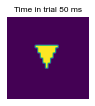

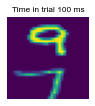

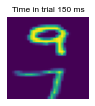

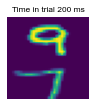

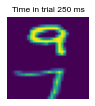

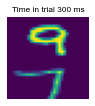

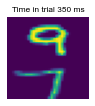

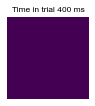

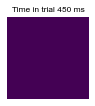

In [27]:
# Create environment from source code
vis_env = MyTask(dt=50)
vis_env.reset(no_step=True)

# Loop through several time steps
for i in range(9):
    ob, _, _, _ = vis_env.step(action=0)  # keep choosing action 0
    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(ob[0])
    plt.title('Time in trial {:d} ms'.format(vis_env.t))
    plt.axis('off')
    plt.show()